In [35]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
import s3fs
import fastparquet
import awswrangler as wr
import os

import pyarrow.parquet as pq
import pyarrow as pa

import requests
import json
from io import BytesIO
from pandas.tseries.offsets import BDay

import math

In [37]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')

OBJETIVO DE ESTE NOTEBOOK:
- DESCARGAR DE DISTINTOS ORIGENES LOS DATOS DE LOS ACTIVOS DEL IBEX35
- COMPARAR LOS DATOS OBTENIDOS 

## CARGA DE COMPOSICIÓN HISTÓRICA DE IBEX35

In [38]:
# LEEMOS EL FICHERO CON LA COMPOSICIÓN HISTORICA
ibex_constituents = pd.read_excel('data_processing/Historical Composition IBEX35.xlsx')
ibex_constituents.head()

,Activo,Inclusion,Exclusion
0,ACE,1991-01-02,2003-06-02
1,ACX,1991-01-02,1991-07-01
2,ALB,1991-01-02,1991-07-01
3,ASL,1991-01-02,1994-01-03
4,BBV,1991-01-02,2000-01-31


In [39]:
# ibex_constituents['Exclusion'] -= BDay(1)

# ibex_constituents['Inclusion'] = ibex_constituents['Inclusion'].dt.date
# ibex_constituents['Exclusion'] = ibex_constituents['Exclusion'].dt.date

# OBTENEMOS EL DIA ACTUAL
today = datetime.date.today().strftime('%Y-%m-%d')

# COMPLETAMOS LOS DATOS NULOS EN EL FICHERO DE COMPOSICIÓN HISTORICA CON LA FECHA ACTUAL
ibex_constituents.fillna(today,inplace=True)

# DEFINIMOS UNA VARIABLE PARA TODOS LOS ACTIVOS
activos = ibex_constituents.Activo
ibex_constituents['Ticker'] = activos.apply(lambda x: x.split('_')[0])

unique_activos = list(set(activos))

### DESCARGAMOS LOS DATOS DE YAHOO FINANCE

In [46]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
raw_folder = 'raw/yfinance/'
s3 = boto3.resource('s3')
failed_loads = []

indexes = ibex_constituents[ibex_constituents['Activo'].isin(['SCYR','SCYR_1','SCYR_2'])].index

# for i in range(ibex_constituents.shape[0]):
for i in indexes:

    try:
        ticker = ibex_constituents.Ticker[i] + '.MC'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        full_path = raw_folder + file_name
        
        stock = yf.download(ticker)
        stock = pd.DataFrame(stock)
        
        table = pa.Table.from_pandas(stock)
        buf = BytesIO()
        pq.write_table(table, buf)

        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ibex_constituents.Activo[i])
    except:
        failed_loads.append(ticker)
        continue



AttributeError: 'str' object has no attribute 'unique'

In [40]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
preprocessed_folder = 'preprocessed/yfinance/'
s3 = boto3.resource('s3')
failed_loads = []

indexes = ibex_constituents[ibex_constituents['Activo'].isin(['SCYR','SCYR_1','SCYR_2'])].index

# for i in range(ibex_constituents.shape[0]):
for i in indexes:

    try:
        ticker = ibex_constituents.Ticker[i] + '.MC'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        start_date = ibex_constituents.Inclusion[i]
        end_date = ibex_constituents.Exclusion[i]
        full_path = preprocessed_folder + file_name
        
        stock = yf.download(ticker, start=start_date, end=end_date)
        print(stock)
        stock = pd.DataFrame(stock)
        
        table = pa.Table.from_pandas(stock)
        buf = BytesIO()
        pq.write_table(table, buf)

        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ibex_constituents.Activo[i])
    except:
        failed_loads.append(ticker)
        continue



[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2003-06-02  8.086692  8.128164  7.895933  8.086692   5.068855  6043269
2003-06-03  8.078402  8.161336  7.937396  8.078402   5.063657   822236
2003-06-04  8.119864  8.169636  8.003749  8.119864   5.089646  1372029
2003-06-05  8.169636  8.169636  8.078402  8.169636   5.120844   742405
2003-06-06  8.045221  8.235989  8.045221  8.045221   5.042859   563733
...              ...       ...       ...       ...        ...      ...
2004-06-24  9.704034  9.836740  9.662563  9.704034   6.293741   353856
2004-06-25  9.704034  9.828440  9.662563  9.704034   6.293741   366200
2004-06-28  9.596210  9.745506  9.596210  9.596210   6.223811   794648
2004-06-29  9.488385  9.604501  9.405442  9.488385   6.197623   651007
2004-06-30  9.330798  9.496676  9.289326  9.330798   6.094692  6042853

[283 ro

In [20]:

# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
preprocessed_folder = 'preprocessed/yfinance/'
s3 = boto3.resource('s3')
failed_loads = []
i = ibex_constituents[ibex_constituents['Activo']=='ELE_1'].index[0]

ticker = ibex_constituents.Ticker[i] + '.MC'
file_name = ibex_constituents.Activo[i] +'.parquet'
start_date = ibex_constituents.Inclusion[i]
end_date = ibex_constituents.Exclusion[i]
full_path = preprocessed_folder + file_name

stock = yf.download(ticker, start=start_date, end=end_date)
print(stock)
stock = pd.DataFrame(stock)

table = pa.Table.from_pandas(stock)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
print(ibex_constituents.Activo[i])


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-12-22  16.100000  16.299999  15.980000  16.170000   8.759433   3675898
2014-12-23  16.200001  16.514999  16.080000  16.465000   8.919236  12020651
2014-12-24  16.400000  16.700001  16.400000  16.565001   8.973409    441635
2014-12-29  16.475000  16.570000  16.200001  16.570000   8.976115   8813922
2014-12-30  16.495001  16.575001  16.379999  16.485001   8.930071   2517169
...               ...        ...        ...        ...        ...       ...
2023-08-03  18.780001  18.924999  18.674999  18.754999  18.754999    969310
2023-08-04  18.809999  18.950001  18.730000  18.950001  18.950001   1640078
2023-08-07  18.900000  18.975000  18.620001  18.805000  18.805000    570979
2023-08-08  18.730000  19.035000  18.709999  18.870001  18.870001    732483
2023-08-09  18.9500

In [18]:
ibex_constituents[ibex_constituents['Activo']=='ELE_1'].index[0]

Int64Index([145], dtype='int64')

In [10]:
negative_adj_close = stock[stock['Adj Close']<0].index
stock.loc[negative_adj_close,'Close']

Date
2000-01-03    19.010000
2000-01-04    18.500000
2000-01-05    18.639999
2000-01-07    19.309999
2000-01-10    19.309999
                ...    
2000-06-26    21.250000
2000-06-27    20.850000
2000-06-28    20.690001
2000-06-29    20.160000
2000-06-30    20.290001
Name: Close, Length: 124, dtype: float64

In [41]:
stock_prices = pq.read_table(download_s3_parquet_file(s3, bucket_name,raw_filepaths[i])).to_pandas()
stock_prices.index = pd.to_datetime(stock_prices.index).strftime('%Y-%m-%d')
negative_adj_close = stock[stock['Adj Close']<0].index
if negative_adj_close is None:
    close_price = stock_prices['Adj Close']
else:
    close_price = stock_prices['Close']

close_price.index = pd.to_datetime(close_price.index).strftime('%Y-%m-%d')
close_price

Date
2020-10-19    17.330000
2020-10-20    17.350000
2020-10-21    16.860001
2020-10-22    16.299999
2020-10-23    15.800000
                ...    
2023-08-02    13.590000
2023-08-03    13.485000
2023-08-04    13.685000
2023-08-07    13.430000
2023-08-08    13.515000
Name: Close, Length: 720, dtype: float64

In [42]:
preprocessed_folder = 'preprocessed/yfinance/'
raw_path = bucket_name + preprocessed_folder
objects_dict = s3_client.list_objects_v2(
        Bucket=bucket_name,
        Prefix ='preprocessed/yfinance')
raw_filepaths = [item['Key'] for item in objects_dict['Contents'] if item['Key'].endswith('.parquet')]
act_list = [i.split('/')[-1].replace('.parquet','') for i in raw_filepaths]

In [43]:
ibex_historical_data = {}
processed_folder = 'processed/yfinance/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [44]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [45]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
for i in range(len(raw_filepaths)):
    
    try:
        stock_prices = pq.read_table(download_s3_parquet_file(s3, bucket_name,raw_filepaths[i])).to_pandas()
        stock_prices.index = pd.to_datetime(stock_prices.index).strftime('%Y-%m-%d')
        negative_adj_close = stock[stock['Adj Close']<0].index
        if negative_adj_close is None:
            close_price = stock_prices['Adj Close']
        else:
            close_price = stock_prices['Close']

        close_price.index = pd.to_datetime(close_price.index).strftime('%Y-%m-%d')
        ibex_historical_data[act_list[i]] = close_price
    except:
        ibex_historical_data[act_list[i]] = np.nan
        
ibex_historical_data = pd.DataFrame(ibex_historical_data)

table = pa.Table.from_pandas(ibex_historical_data)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

{'ResponseMetadata': {'RequestId': 'JDDWH47C7XKJNJ5T',
  'HostId': 'lShY+wbMlRImAr3hvtu54Xit+NLCwL3IkapxQCjmSOS9UVzzOj16iie6SnCuoqgKe6wbOFRV71w=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'lShY+wbMlRImAr3hvtu54Xit+NLCwL3IkapxQCjmSOS9UVzzOj16iie6SnCuoqgKe6wbOFRV71w=',
   'x-amz-request-id': 'JDDWH47C7XKJNJ5T',
   'date': 'Fri, 11 Aug 2023 08:36:49 GMT',
   'x-amz-version-id': 'iyp.dfxKxD9D15qsXtheFphsJoH0_99K',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"26370f2eed79dc42f5e62439265e609e"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"26370f2eed79dc42f5e62439265e609e"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'iyp.dfxKxD9D15qsXtheFphsJoH0_99K'}

In [33]:
ibex_historical_data

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACE,ACR,ACS,ACX,ACX_1,...,URB,VAL,VAL_1,VDR,VIS,VIS_1,VIS_2,VIS_3,ZEL,ZOT
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.150000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.360001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.440001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


KeyboardInterrupt: 

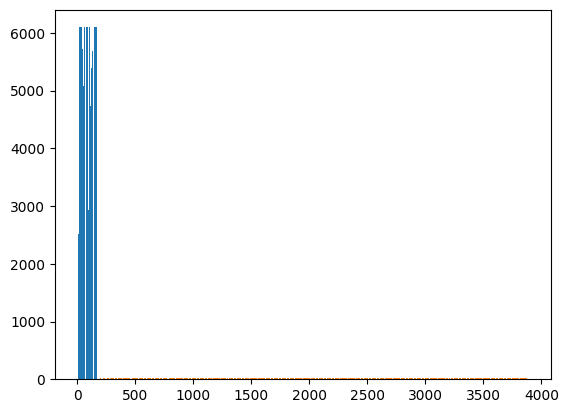

In [34]:
plt.bar(range(ibex_historical_data.shape[1]),ibex_historical_data.isnull().sum())
plt.bar(range(ibex_historical_data.shape[0]),ibex_historical_data.notna().sum(axis=1))

In [ ]:
failed_loads = ibex_historical_data.columns[ibex_historical_data.isnull().values.all(axis=0)]
failed_loads, len(failed_loads)

(Index(['A3TV', 'ABG.P', 'ABG.P_1', 'ABG', 'ACE', 'ACR', 'ACX', 'AGR', 'AGS',
        'AGS_1',
        ...
        'UNI', 'URA', 'URB', 'VAL', 'VAL_1', 'VDR', 'VIS', 'VIS_1', 'ZEL',
        'ZOT'],
       dtype='object', length=105),
 105)